Date          Person      Change
04/15/2019    L. Hunt     Changed correction to get synthetic and apparent magnitudes to match 
                          Changed way the catalogs were read in
                          Changed some plots

In [1]:
import pandas as pd
import numpy as np
import astropy as ap
from astropy import units as u
from astropy.coordinates import SkyCoord
import kcorrect
import kcorrect.utils as ut
from astropy.cosmology import FlatLambdaCDM
import os
import matplotlib.pyplot as plt
from itertools import combinations

#***************************
# Setting up Environment and Making useful functions
#***************************

Setting up Cosmology

In [33]:
print('Setting up Environment')
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)

kcordir=os.environ["KCORRECT_DIR"]

catbasedir=os.environ["COSMOS_DIR"]

Setting up Environment


This task will make a kcorrect filter template from a dataframe that optimizes the number of objects with detections in a subset of filters. In this case the dataframe should contain cfht, subaru, and irac wideband filters.

In [3]:
def make_kcorr_filt_template(dataframe):
    '''This task will make a kcorrect filter template from a dataframe that optimizes the number of objects with detections in a subset of filters. In this case the dataframe should contain cfht, subaru, and irac wideband filters. '''
    kcordir=os.environ["KCORRECT_DIR"]
    lambdar_to_kcorr={'mag_cfht_u':'capak_cfht_megaprime_sagem_u.par','mag_subaru_B':'capak_subaru_suprimecam_B.par','mag_subaru_V':'capak_subaru_suprimecam_V.par','mag_subaru_g':'capak_subaru_suprimecam_g.par','mag_subaru_r':'capak_subaru_suprimecam_r.par','mag_subaru_i':'capak_subaru_suprimecam_i.par','mag_subaru_z':'capak_subaru_suprimecam_z.par','mag_irac_1':'spitzer_irac_ch1.par','mag_irac_2':'spitzer_irac_ch2.par','mag_irac_3':'spitzer_irac_ch3.par','mag_irac_4':'spitzer_irac_ch4.par'}
    numb1=0
    numb2=0
    numb3=0
    numb4=0
    numb5=0
    flist1=[]
    flist2=[]
    flist3=[]
    flist4=[]
    flist5=[]
    ilist1=[]
    ilist2=[]
    ilist3=[]
    ilist4=[]
    ilist5=[]
    kcor_template=kcordir+'/data/templates/temp_filt_list.dat'
    for x in combinations(list(dataframe),5):
        if len(dataframe[(dataframe[x[0]]<40)&(dataframe[x[1]]<40)&(dataframe[x[2]]<40)&(dataframe[x[3]]<40)&(dataframe[x[4]]<40)]) > numb1:
            ilist5=ilist4
            ilist4=ilist3
            ilist3=ilist2
            ilist2=ilist1
            ilist1=dataframe[(dataframe[x[0]]<40)&(dataframe[x[1]]<40)&(dataframe[x[2]]<40)&(dataframe[x[3]]<40)&(dataframe[x[4]]<40)].index.tolist()
            numb5=numb4
            numb4=numb3
            numb3=numb2
            numb2=numb1
            numb1=len(ilist1)
            flist5=flist4
            flist4=flist3
            flist3=flist2
            flist2=flist1
            flist1=x
    with open(kcor_template,'w') as file:
        file.write('KCORRECT_DIR\n')
        for filt in flist1:
            file.write('data/filters/'+lambdar_to_kcorr[filt]+'\n')
    return flist1,kcor_template

Need to make a dictionary to match column datatypes that are alread available in the Zurich Morphology Catalog

In [34]:
typedict={'float':np.float64,'string':str}

with open('/Users/lucashunt/ASTRODATA/LCBG_LUMINOSITY_FUNCTION/COSMOS_CATALOGS/Morphology/cosmos_morph_zurich_1.0.tbl') as zurich:
    header=zurich.readline()
    thetype=zurich.readline()
    zurich_dictionary=dict(zip(header.split(),
                               [typedict[f] for f in thetype.split()]))
    
typedict={'char':str,'double':np.float64,'float':np.float64,'int':np.int}

with open(catbasedir+'/Spectroscopy/deimos_10k_March2018/deimos_redshifts.tbl') as deimos:
    file=deimos.readlines()
    for line in file:
        deimos_dict=dict(zip(file[71].split(),
                             [typedict[f] for f in file[72].split()]))

Now need to read in GAMA Catalog, and 3 COSMOS Morphology Catalogs
Catalogs
* 

In [63]:
print('Reading in Catalogs')
COSMOS_PHOT_LAMBDAR=pd.read_csv('/Users/lucashunt/ASTRODATA/LCBG_Luminosity_Function/COSMOS_CATALOGS/Photometry/G10CosmosLAMBDARCatv05.csv')

deimos_df=pd.read_csv(
    catbasedir+'/Spectroscopy/deimos_10k_March2018/deimos_redshifts.tbl',     delim_whitespace=True,
    header=71,
    dtype=deimos_dict,
    error_bad_lines=False,
    skiprows=[72,73,74])

with open(catbasedir+'/Spectroscopy/deimos_10k_March2018/deimos_redshifts.tbl') as deimos:
    file=deimos.readlines()
    i=0
    for line in file:
        if (len(line.split())==11) & (i>74):
            x=line.split()
            del x[3]
            x_series=pd.Series(x,index=file[71].split())
            deimos_df=deimos_df.append(x_series,ignore_index=True)
        i=i+1

TASCA_COSMOS_MORPH=pd.read_csv(
    '/Users/lucashunt/ASTRODATA/LCBG_LUMINOSITY_FUNCTION/COSMOS_CATALOGS/Morphology/cosmos_morph_tasca_1.1.tbl',
    delim_whitespace=True,
    header=0,
    dtype=float,
    error_bad_lines=False,
    skiprows=[1,2,3])

CASSATA_COSMOS_MORPH=pd.read_csv('/Users/lucashunt/ASTRODATA/LCBG_LUMINOSITY_FUNCTION/COSMOS_CATALOGS/Morphology/cosmos_morph_cassata_1.1.tbl',
                                 delim_whitespace=True,
                                 header=0,
                                 dtype=float,
                                 error_bad_lines=False,
                                 skiprows=[1,2,3])

ZURICH_COSMOS_MORPH=pd.read_csv('/Users/lucashunt/ASTRODATA/LCBG_LUMINOSITY_FUNCTION/COSMOS_CATALOGS/Morphology/cosmos_morph_zurich_1.0.tbl',
                                delim_whitespace=True,
                                header=0,
                                error_bad_lines=False,
                                skiprows=[1,2,3],
                                dtype=zurich_dictionary)

Spec_Cat=pd.read_csv(catbasedir+'/Final_Catalogs/Laigle_Cat_With_kcorrections.csv')

Reading in Catalogs


b'Skipping line 136: expected 10 fields, saw 11\nSkipping line 142: expected 10 fields, saw 11\nSkipping line 144: expected 10 fields, saw 11\nSkipping line 147: expected 10 fields, saw 11\nSkipping line 150: expected 10 fields, saw 11\nSkipping line 153: expected 10 fields, saw 11\nSkipping line 158: expected 10 fields, saw 11\nSkipping line 160: expected 10 fields, saw 11\nSkipping line 175: expected 10 fields, saw 11\nSkipping line 191: expected 10 fields, saw 11\nSkipping line 196: expected 10 fields, saw 11\nSkipping line 221: expected 10 fields, saw 11\nSkipping line 226: expected 10 fields, saw 11\nSkipping line 232: expected 10 fields, saw 11\nSkipping line 237: expected 10 fields, saw 11\nSkipping line 242: expected 10 fields, saw 11\nSkipping line 253: expected 10 fields, saw 11\nSkipping line 271: expected 10 fields, saw 11\nSkipping line 290: expected 10 fields, saw 11\nSkipping line 309: expected 10 fields, saw 11\nSkipping line 321: expected 10 fields, saw 11\nSkipping li

In [96]:
COSMOS_PHOT_LAMBDAR.columns

Index(['CATAID', 'COSMOS_ID_06', 'COSMOS_ID_08', 'COSMOS_ID_13', 'I_MAG_AUTO',
       'RA', 'DEC', 'RA_06', 'DEC_06', 'RA_COSMOS2015',
       ...
       'Z_BEST', 'Z_GEN', 'Z_USE', 'ZP_COSMOS2015', 'ZL68_COSMOS2015',
       'ZH68_COSMOS2015', 'ZP_EAZY16', 'r_half_cassata', 'r_half_tasca',
       'r_half_zurich'],
      dtype='object', length=109)

In [64]:
TASCA_COSMOS_MORPH.columns=TASCA_COSMOS_MORPH.columns.str.lower()
CASSATA_COSMOS_MORPH.columns=CASSATA_COSMOS_MORPH.columns.str.lower()
ZURICH_COSMOS_MORPH.columns=ZURICH_COSMOS_MORPH.columns.str.lower()

In [65]:
TASCA_COSMOS_MORPH

,id,ra,dec,acs_mag_auto,axial_ratio,r_half,gini,conc,asymmetry,class_int,class_linee,class_svm
0,13.0,149.491501,2.493024,23.339855,0.267504,15.329414,0.35647,0.1974,0.04962,2.0,2.0,2.0
1,15.0,149.485535,2.460556,22.602184,0.797003,11.095497,0.45149,0.2623,0.06262,2.0,2.0,2.0
2,16.0,149.490829,2.489961,23.777929,0.290134,12.299197,0.41470,0.2196,0.07023,2.0,2.0,2.0
3,17.0,149.484085,2.452666,22.474968,0.890823,11.447604,0.41471,0.2519,0.09750,2.0,2.0,3.0
4,18.0,149.491867,2.496497,23.957480,0.977324,2.473022,0.70214,0.4749,0.16333,1.0,1.0,1.0
5,19.0,149.487167,2.474067,24.468685,0.728482,4.195738,0.49444,0.3001,0.07727,2.0,2.0,3.0
6,20.0,149.490418,2.492819,24.633381,0.649270,4.310167,0.53258,0.2818,0.08942,2.0,2.0,3.0
7,21.0,149.491379,2.499063,22.866400,0.555978,11.666937,0.48782,0.2929,0.12287,2.0,2.0,3.0
8,22.0,149.484833,2.461573,24.240602,0.461409,7.855376,0.43770,0.1285,0.02649,3.0,2.0,3.0
9,23.0,149.483322,2.454827,21.982880,0.395685,21.035694,0.49740,0.2491,0.31499,3.0,3.0,3.0


Making dataframe to contain all morphology catalogs

In [66]:
HALF_LIGHT_RADII=CASSATA_COSMOS_MORPH.copy()

In [67]:
HALF_LIGHT_RADII=HALF_LIGHT_RADII.rename(columns={'r_half':'r_half_cassata'})

Setting Variables

*********************************************
Matching Catalogs
*********************************************

In [68]:
print('Matching Catalogs')

Matching Catalogs


Generating Astropy skycoord objects to easily match catalogs based on position

In [69]:
CASSATA_COORD=SkyCoord(ra=CASSATA_COSMOS_MORPH['ra'].values*u.degree,
                       dec=CASSATA_COSMOS_MORPH['dec'].values*u.degree)

ZURICH_COORD=SkyCoord(ra=ZURICH_COSMOS_MORPH['ra'].values*u.degree,
                      dec=ZURICH_COSMOS_MORPH['dec'].values*u.degree)

TASCA_COORD=SkyCoord(ra=TASCA_COSMOS_MORPH['ra'].values*u.degree,
                     dec=TASCA_COSMOS_MORPH['dec'].values*u.degree)

G10_COORD=SkyCoord(ra=COSMOS_PHOT_LAMBDAR['RA'].values*u.degree,
                   dec=COSMOS_PHOT_LAMBDAR['DEC'].values*u.degree)

RH_COORD=SkyCoord(ra=HALF_LIGHT_RADII['ra'].values*u.degree,
                  dec=HALF_LIGHT_RADII['dec'].values*u.degree)

deimos_coord=SkyCoord(ra=deimos_df['Ra'].values*u.degree,
                     dec=deimos_df['Dec'].values*u.degree)


Matching Catalogs

In [70]:
idxCASSATA_t,idxTASCA_c,d2d_ct,d3d_tc=TASCA_COORD.search_around_sky(CASSATA_COORD,1*u.arcsecond)
idxCASSATA_z,idxZURICH_c,d2d_cz,d3d_zc=ZURICH_COORD.search_around_sky(CASSATA_COORD,1*u.arcsecond)

In [71]:
mask_cz=np.ones(len(idxCASSATA_z),dtype=bool)
separation_list=[]
three_obj_within_1_arcsec=[]
for i in range(0,len(idxCASSATA_z)-2):
    if idxZURICH_c[i]==idxZURICH_c[i+1]:
        separation_list.append(
            [d2d_cz[i].arcsecond,
             d2d_cz[i+1].arcsecond])
        if d2d_cz[i]>d2d_cz[i+1]:
            mask_cz[i]=False
        if d2d_cz[i]<d2d_cz[i+1]:
            mask_cz[i+1]=False
        if d2d_cz[i]==d2d_cz[i+1]:
            mask_cz[i+1]=False
    if idxZURICH_c[i]==idxZURICH_c[i+2]:
        three_objs=d2d_cz[i:i+3].arcsecond
        three_objs_dict={d2d_cz[i].arcsecond:str(i+1)+' '+str(i+2),
                         d2d_cz[i+1].arcsecond:str(i)+' '+str(i+2),
                         d2d_cz[i+2].arcsecond:str(i)+' '+str(i+1)}
        further_objs=np.array(
            three_objs_dict[min(three_objs)].split()).astype('int')
        mask_cz[further_objs]=False
        three_obj_within_1_arcsec.append(
            [d2d_cz[i].arcsecond,
             d2d_cz[i+1].arcsecond,
             d2d_cz[i+2].arcsecond])
        three_obj_within_1_arcsec.append([d2d_cz[i].arcsecond,
                                          d2d_cz[i+1].arcsecond,
                                          d2d_cz[i+2].arcsecond])

In [72]:
mask_ct=np.ones(len(idxCASSATA_t),dtype=bool)
separation_list=[]
three_obj_within_1_arcsec=[]
for i in range(0,len(idxCASSATA_t)-2):
    if idxTASCA_c[i]==idxTASCA_c[i+1]:
        separation_list.append(
            [d2d_ct[i].arcsecond,
             d2d_ct[i+1].arcsecond])
        if d2d_ct[i]>d2d_ct[i+1]:
            mask_ct[i]=False
        if d2d_ct[i]<d2d_ct[i+1]:
            mask_ct[i+1]=False
        if d2d_ct[i]==d2d_ct[i+1]:
            mask_ct[i+1]=False
    if idxTASCA_c[i]==idxTASCA_c[i+2]:
        three_objs=d2d_ct[i:i+3].arcsecond
        three_objs_dict={d2d_ct[i].arcsecond:str(i+1)+' '+str(i+2),
                         d2d_ct[i+1].arcsecond:str(i)+' '+str(i+2),
                         d2d_ct[i+2].arcsecond:str(i)+' '+str(i+1)}
        further_objs=np.array(
            three_objs_dict[min(three_objs)].split()).astype('int')
        mask_ct[further_objs]=False
        three_obj_within_1_arcsec.append(
            [d2d_ct[i].arcsecond,
             d2d_ct[i+1].arcsecond,
             d2d_ct[i+2].arcsecond])
        three_obj_within_1_arcsec.append([d2d_ct[i].arcsecond,
                                          d2d_ct[i+1].arcsecond,
                                          d2d_ct[i+2].arcsecond])

In [73]:
idxCASSATA_t=idxCASSATA_t[mask_ct]
idxTASCA_c=idxTASCA_c[mask_ct]
idxCASSATA_z=idxCASSATA_z[mask_cz]
idxZURICH_c=idxZURICH_c[mask_cz]

In [74]:
HALF_LIGHT_RADII.loc[HALF_LIGHT_RADII.index[idxCASSATA_t],'r_half_tasca']=np.array(TASCA_COSMOS_MORPH.r_half[idxTASCA_c])
HALF_LIGHT_RADII.loc[HALF_LIGHT_RADII.index[idxCASSATA_t],'acs_mag_tasca']=np.array(TASCA_COSMOS_MORPH.acs_mag_auto[idxTASCA_c])
HALF_LIGHT_RADII.loc[HALF_LIGHT_RADII.index[idxCASSATA_z],'r_half_zurich']=np.array(ZURICH_COSMOS_MORPH.r50[idxZURICH_c])
HALF_LIGHT_RADII.loc[HALF_LIGHT_RADII.index[idxCASSATA_z],'acs_mag_zurich']=np.array(TASCA_COSMOS_MORPH.acs_mag_auto[idxZURICH_c])

In [75]:
HALF_LIGHT_RADII['CASSATA_SB']=HALF_LIGHT_RADII.mag_auto_acs+0.753+2.5*np.log10(np.pi*(HALF_LIGHT_RADII.r_half_cassata*0.03)**2)

In [76]:
HALF_LIGHT_RADII['TASCA_SB']=HALF_LIGHT_RADII.acs_mag_tasca+0.753+2.5*np.log10(np.pi*(HALF_LIGHT_RADII.r_half_tasca*0.03)**2)

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [77]:
HALF_LIGHT_RADII['ZURICH_SB']=HALF_LIGHT_RADII.acs_mag_zurich+0.753+2.5*np.log10(np.pi*(HALF_LIGHT_RADII.r_half_zurich*0.03)**2)

In [78]:
HALF_LIGHT_RADII[['r_half_cassata','r_half_tasca','r_half_zurich']]

,r_half_cassata,r_half_tasca,r_half_zurich
0,8.715000,7.213745,NaN
1,7.472000,4.458507,8.288739
2,5.731000,4.067095,6.034099
3,5.328000,4.538128,NaN
4,2.124000,2.443445,-999999.000000
5,9.356000,15.329414,19.060892
6,8.720000,NaN,13.489996
7,11.486000,12.299197,19.672527
8,2.269000,2.473022,-999999.000000
9,14.414000,11.095497,15.871347


TASCA_COSMOS_MORPH

In [79]:
idxRH,idxG10,d2dG10,d3dG10=G10_COORD.search_around_sky(RH_COORD,1*u.arcsecond)

In [80]:
mask_rh=np.ones(len(idxRH),dtype=bool)
separation_list=[]
three_obj_within_1_arcsec=[]
for i in range(0,len(idxRH)-2):
    if idxG10[i]==idxG10[i+1]:
        separation_list.append(
            [d2dG10[i].arcsecond,
             d2dG10[i+1].arcsecond])
        if d2dG10[i]>d2dG10[i+1]:
            mask_rh[i]=False
        if d2dG10[i]<d2dG10[i+1]:
            mask_rh[i+1]=False
        if d2dG10[i]==d2dG10[i+1]:
            mask_rh[i+1]=False
    if idxG10[i]==idxG10[i+2]:
        three_objs=d2dG10[i:i+3].arcsecond
        three_objs_dirh={d2dG10[i].arcsecond:str(i+1)+' '+str(i+2),
                         d2dG10[i+1].arcsecond:str(i)+' '+str(i+2),
                         d2dG10[i+2].arcsecond:str(i)+' '+str(i+1)}
        further_objs=np.array(
            three_objs_dirh[min(three_objs)].split()).astype('int')
        mask_rh[further_objs]=False
        three_obj_within_1_arcsec.append(
            [d2dG10[i].arcsecond,
             d2dG10[i+1].arcsecond,
             d2dG10[i+2].arcsecond])
        three_obj_within_1_arcsec.append([d2dG10[i].arcsecond,
                                          d2dG10[i+1].arcsecond,
                                          d2dG10[i+2].arcsecond])

In [81]:
idxG10=idxG10[mask_rh]
idxRH=idxRH[mask_rh]

In [82]:
COSMOS_PHOT_LAMBDAR['r_half_cassata']=np.nan
COSMOS_PHOT_LAMBDAR['r_half_tasca']=np.nan
COSMOS_PHOT_LAMBDAR['r_half_zurich']=np.nan
COSMOS_PHOT_LAMBDAR.loc[idxG10,['r_half_cassata','r_half_tasca','r_half_zurich']]=np.array(HALF_LIGHT_RADII.loc[idxRH,['r_half_cassata','r_half_tasca','r_half_zurich']])*0.03

In [83]:
COSMOS_FLUXES=COSMOS_PHOT_LAMBDAR.copy()

In [98]:
COSMOS_FLUXES.columns
Spec_Cat.columns

Index(['NUMBER', 'ID2006', 'ID2008', 'RA', 'DEC', 'FLUX_RADIUS', 'u_MAG_AUTO',
       'u_MAGERR_AUTO', 'B_MAG_AUTO', 'B_MAGERR_AUTO', 'V_MAG_AUTO',
       'V_MAGERR_AUTO', 'r_MAG_AUTO', 'r_MAGERR_AUTO', 'ip_MAG_AUTO',
       'ip_MAGERR_AUTO', 'zpp_MAG_AUTO', 'zpp_MAGERR_AUTO', 'Y_MAG_AUTO',
       'Y_MAGERR_AUTO', 'J_MAG_AUTO', 'J_MAGERR_AUTO', 'H_MAG_AUTO',
       'H_MAGERR_AUTO', 'Ks_MAG_AUTO', 'Ks_MAGERR_AUTO', 'ZPDF', 'TYPE',
       'deimos_id', 'deimos_ra', 'deimos_dec', 'deimos_zspec', 'deimos_qf',
       'deimos_q', 'catalog', 'ID_06', 'Z_USE', 'Z_BEST', 'final_z',
       'final_use', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'u_maggies',
       'u_invervar', 'B_maggies', 'B_invervar', 'V_maggies', 'V_invervar',
       'r_maggies', 'r_invervar', 'ip_maggies', 'ip_invervar', 'zpp_maggies',
       'zpp_invervar', 'Y_maggies', 'Y_invervar', 'J_maggies', 'J_invervar',
       'H_maggies', 'H_invervar', 'Ks_maggies', 'Ks_invervar',
       'B_synthetic_maggies', 'B0_synthetic_maggies', 'V_sy

In [99]:
combine_laigle_andrews=pd.merge(left=Spec_Cat,
                                right=COSMOS_FLUXES[['COSMOS_ID_08',
                                                     'r_half_cassata',
                                                     'r_half_tasca',
                                                     'r_half_zurich']],
                                how='left',
                                left_on=['ID2008'],
                                right_on=['COSMOS_ID_08'])

In [104]:
combine_laigle_andrews['FLUX_RADIUS_arcsec_B']=((1.12*(1+combine_laigle_andrews.final_z)**(-0.108))*
                                                (combine_laigle_andrews.FLUX_RADIUS.values*0.15))
combine_laigle_andrews['r_half_cassata_B']=((1.06*(1+combine_laigle_andrews.final_z)**(-0.108))*
                                                (combine_laigle_andrews.r_half_cassata.values))
combine_laigle_andrews['r_half_tasca_B']=((1.06*(1+combine_laigle_andrews.final_z)**(-0.108))*
                                                (combine_laigle_andrews.r_half_tasca.values))
combine_laigle_andrews['r_half_zurich_B']=((1.06*(1+combine_laigle_andrews.final_z)**(-0.108))*
                                                (combine_laigle_andrews.r_half_zurich.values))
combine_laigle_andrews.loc[(combine_laigle_andrews.final_use==1)&(combine_laigle_andrews.r_half_tasca.notnull())&(combine_laigle_andrews.ID2006>0),
                           ['FLUX_RADIUS_arcsec_B',
                            'r_half_cassata_B',
                            'r_half_tasca_B',
                            'r_half_zurich_B']]
combine_laigle_andrews.loc[(combine_laigle_andrews.final_use==1)&(combine_laigle_andrews.r_half_tasca.notnull()),
                           ['FLUX_RADIUS_arcsec_B',
                            'r_half_cassata_B',
                            'r_half_tasca_B',
                            'r_half_zurich_B']]


,FLUX_RADIUS_arcsec_B,r_half_cassata_B,r_half_tasca_B,r_half_zurich_B
70050,0.813318,0.359212,0.807042,0.937564
70113,0.822861,0.356039,0.374503,0.537470
70297,0.946026,0.572898,0.441283,0.576581
70308,0.696769,0.341469,0.319946,0.375579
70319,0.675771,0.284064,0.279571,0.343312
70343,0.633934,0.270417,0.332911,0.386011
70479,0.733450,0.313732,0.155985,0.293736
70501,0.932464,0.588492,0.590213,0.826963
70591,0.710301,0.395756,0.624543,0.672965
70652,0.950298,0.643719,0.604780,0.798543


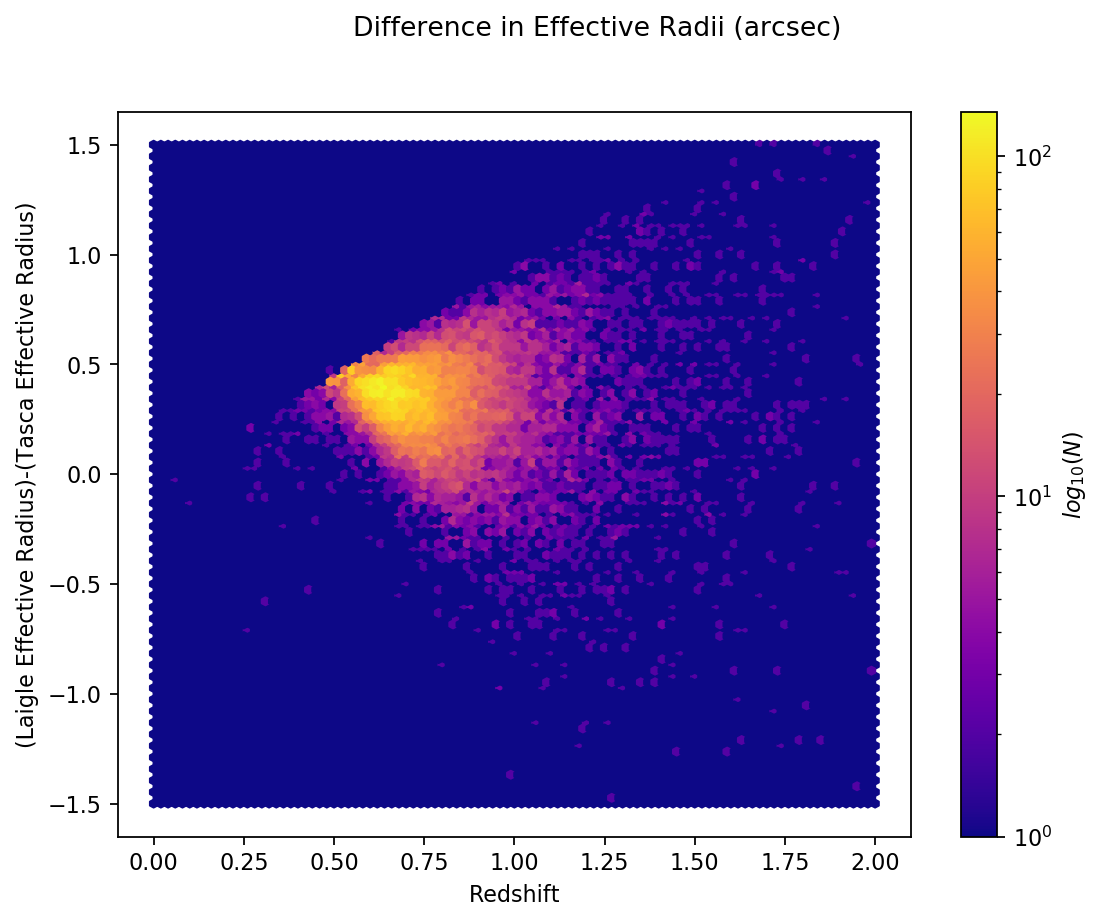

In [118]:
plt.figure(figsize=(8,6),dpi=160)
plt.hexbin(combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                      'FLUX_RADIUS_arcsec_B'],
           combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                      'FLUX_RADIUS_arcsec_B']-combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                                                                   'r_half_tasca_B'],
           gridsize=100,
           cmap='plasma',
           extent=[0, 2, -1.5, 1.5],
           bins='log')
plt.xlabel('Redshift')
plt.ylabel('(Laigle Effective Radius)-(Tasca Effective Radius)')
cb=plt.colorbar()
cb.set_label('$log_{10}(N)$')
plt.suptitle('Difference in Effective Radii (arcsec)')
plt.savefig('/Users/lucashunt/Projects/LCBG_LUMINOSITY_FUNCTION/CODE/Combine_Spec_Folder/Compare_Laigle_Tasca_REFF.png')

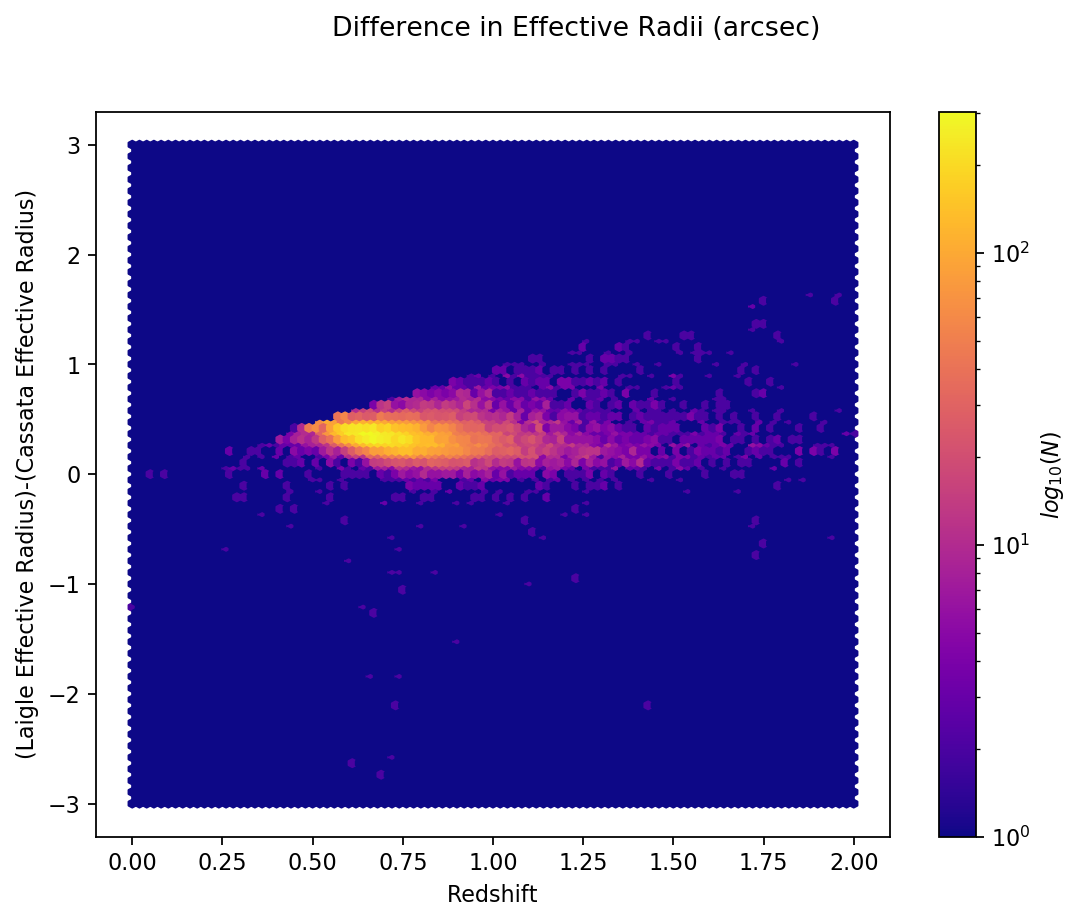

In [119]:
plt.figure(figsize=(8,6),dpi=160)
plt.hexbin(combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                      'FLUX_RADIUS_arcsec_B'],
           combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                      'FLUX_RADIUS_arcsec_B']-combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                                                                   'r_half_cassata_B'],
           gridsize=100,
           cmap='plasma',
           extent=[0, 2, -3, 3],
          bins='log')
plt.xlabel('Redshift')
plt.ylabel('(Laigle Effective Radius)-(Cassata Effective Radius)')
cb=plt.colorbar()
cb.set_label('$log_{10}(N)$')
plt.suptitle('Difference in Effective Radii (arcsec)')
plt.savefig('/Users/lucashunt/Projects/LCBG_LUMINOSITY_FUNCTION/CODE/Combine_Spec_Folder/Compare_Laigle_Cassata_REFF.png')

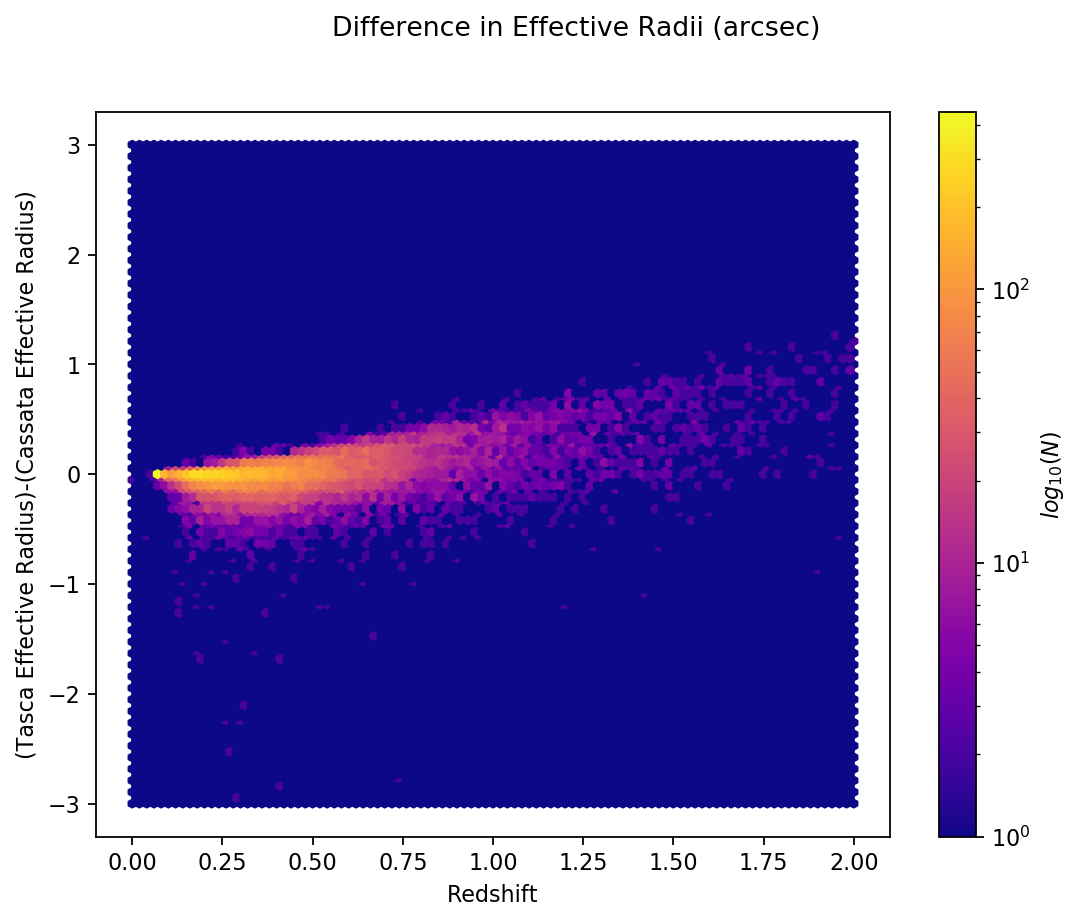

In [120]:
plt.figure(figsize=(8,6),dpi=160)
plt.hexbin(combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                      'r_half_tasca_B'],
           combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                      'r_half_tasca_B']-combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                                                                   'r_half_cassata_B'],
           gridsize=100,
           cmap='plasma',
           extent=[0, 2, -3, 3],
          bins='log')
plt.xlabel('Redshift')
plt.ylabel('(Tasca Effective Radius)-(Cassata Effective Radius)')
cb=plt.colorbar()
cb.set_label('$log_{10}(N)$')
plt.suptitle('Difference in Effective Radii (arcsec)')
plt.savefig('/Users/lucashunt/Projects/LCBG_LUMINOSITY_FUNCTION/CODE/Combine_Spec_Folder/Compare_Tasca_Cassata_REFF.png')

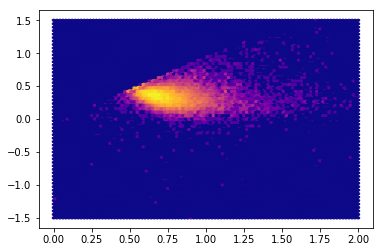

In [103]:
plt.hexbin(combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                      'FLUX_RADIUS_arcsec_B'],
           combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                      'FLUX_RADIUS_arcsec_B']-combine_laigle_andrews.loc[combine_laigle_andrews.final_use==1,
                                                                                   'r_half_cassata_B'],
           gridsize=100,
           cmap='plasma',
           extent=[0, 2, -1.5, 1.5],
           bins='log')